<br/>

$$ \huge{\underline{\textbf{ Gradient Bandit }}} $$

<br/>

<center>Implementation of <b>Gradient Bandit</b></center>
<center>from Sutton and Barto 2018, <b>chapter 2.8</b>.</center>
<center>Book available for free <a href="http://incompleteideas.net/book/the-book-2nd.html">here</a></center>

<br/>

Gradient Bandit uses action preferences and soft-max distribution for action selection. See book equations (2.11) and (2.12).

$$ Pr\{A_t=a\} \doteq \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}} \doteq \pi_t(a) $$

$$ H_{t+1}(A_t) \doteq H_t(A_t) + \alpha(R_t-\bar{R_t})(1-\pi_t(A_t))  $$

$$ H_{t+1}(a) \doteq H_t(a) - \alpha(R_t-\bar{R_t})\pi_t(a) \quad \text{for all} \quad a \neq A_t $$

<br/>

In [1]:
def gradient_bandit(env, nb, alpha, baseline):
    H = np.zeros(env.size)
    R_, N_ = 0.0, 0.0
    hist_A = []
    hist_R = []
    
    for _ in range(nb):
        pi = softmax(H)
        A = np.random.choice(range(env.size), p=pi)
        R = env.step(A)
        
        H_new = H - alpha*(R-R_)*pi               # for all a =/= A
        H_new[A] = H[A] + alpha*(R-R_)*(1-pi[A])  # for a == A
        H = H_new
        
        if baseline:
            N_ += 1
            R_ += 1/N_ * (R-R_)
        
        hist_A.append(A)
        hist_R.append(R)
        
    return H, np.array(hist_A), np.array(hist_R)

Helper functions:

In [2]:
def softmax(x):
    """Numerically stable softmax"""
    ex = np.exp(x - np.max(x))
    return ex / np.sum(ex)

---

<table>
    <tr>
        <td style="border-color: white;"><img src="assets/fig_0205.png"/></td>
    </tr>
    <tr>
        <td style="border-color: white;"><center>Figure 2.5<center/></td>
    </tr>
</table>

# Experiment Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Environment

In [4]:
class BanditEnv:
    def __init__(self):
        """10-armed testbed, see chapter 2.3"""
        self.size = 10                                        # 10 arms
        self.offset = 4
        self.means = np.random.normal(loc=self.offset, scale=1.0, size=self.size)
    def step(self, action):
        return np.random.normal(loc=self.means[action])

# Recreate Figure 2.5

Generate data

In [5]:
runs_base_a01 = []      #  with baseline, alpha=0.1
runs_base_a04 = []      #  with baseline, alpha=0.4
runs_wout_a01 = []      #  without baseline, alpha=0.1
runs_wout_a04 = []      #  without baseline, alpha=0.4


print('v' + ' '*18 + 'v')  # poor man tqdm
for i in range(2000):
    env = BanditEnv()
    max_A = np.argmax(env.means)
    
    _, hist_A, _ = gradient_bandit(env, nb=1000, alpha=0.1, baseline=True)
    runs_base_a01.append(hist_A==max_A)
    
    _, hist_A, _ = gradient_bandit(env, nb=1000, alpha=0.4, baseline=True)
    runs_base_a04.append(hist_A==max_A)
    
    _, hist_A, _ = gradient_bandit(env, nb=1000, alpha=0.1, baseline=False)
    runs_wout_a01.append(hist_A==max_A)
    
    _, hist_A, _ = gradient_bandit(env, nb=1000, alpha=0.4, baseline=False)
    runs_wout_a04.append(hist_A==max_A)
    
    if i % 100 == 0: print('.', end='')
            
runs_base_a01 = np.array(runs_base_a01)
runs_base_a04 = np.array(runs_base_a04)
runs_wout_a01 = np.array(runs_wout_a01)
runs_wout_a04 = np.array(runs_wout_a04)

v                  v
....................

In [6]:
# Calc "% optimal action"
opt_base_a01 = np.average(runs_base_a01, axis=0)
opt_base_a04 = np.average(runs_base_a04, axis=0)
opt_wout_a01 = np.average(runs_wout_a01, axis=0)
opt_wout_a04 = np.average(runs_wout_a04, axis=0)

Plot figure 2.5

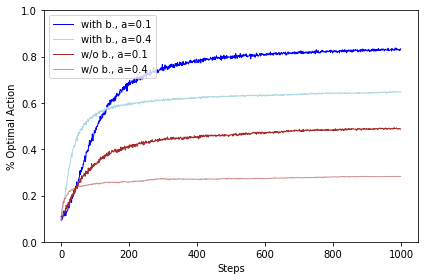

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(opt_base_a01,    linewidth=1., color='blue', label='with b., a=0.1')
ax.plot(opt_base_a04,    linewidth=1., color='lightblue', label='with b., a=0.4')
ax.plot(opt_wout_a01,    linewidth=1., color='brown', label='w/o b., a=0.1')
ax.plot(opt_wout_a04,    linewidth=1., color='brown', alpha=0.5, label='w/o b., a=0.4')
ax.set_xlabel('Steps'); ax.set_ylabel('% Optimal Action')
ax.set_ylim((0.0, 1.0))
ax.legend()
plt.tight_layout()
plt.savefig('assets/fig_0208.png')
plt.show()